In [16]:
import cv2 # opencv 
import os 
import tempfile
from transformers import pipeline
from PIL import Image
import tkinter as tk #GUI
from tkinter import ttk
from pygame import mixer # to operation on audio file

In [17]:
# Initialize the pipeline for image classification
pipe = pipeline("image-classification", model="model_files")  # only initialization of pipeline
# algo 2, image classifier transformer (present inside "model files" folder)

# Initialize the webcam
cap = cv2.VideoCapture(0)

# Flag to control the loop
predict_emotions = False

while predict_emotions != True:
    # Read a frame from the webcam
    ret, frame = cap.read()

    # Display the frame
    cv2.imshow("Press 'C' To Capture Image", frame)

    # Press 'c' to capture a temporary photo and predict emotions
    if cv2.waitKey(1) & 0xFF == ord('c'):
        predict_emotions = True

    if predict_emotions:
        # Detect faces in the frame
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')  # a model which can detect faces , ALGO 1
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        if faces is not None and len(faces) > 0:
            # Consider first detected face for simplicity
            x, y, w, h = faces[0]

            # Crop the face from the frame
            face_roi = frame[y:y + h, x:x + w]

            # Convert to Python Image Library(PIL) image
            face_pil = Image.fromarray(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

            # Resize to 224x224 pixels
            face_resized = face_pil.resize((224, 224))

            # Convert to grayscale (if needed by the model)
            face_gray = face_resized.convert('L')

            with tempfile.TemporaryDirectory() as temp_dir:
                temp_image_path = os.path.join(temp_dir, "temp_photo.jpg")  # photo is saved in a temp_path with name as temp_photo.jpg
                # Save the processed image
                face_gray.save(temp_image_path)  # save method will save the photo in the temp path

                # Predict emotions from the temporary image
                emotions = pipe(temp_image_path)  # calling the pipeline for image emotion classification : input = image in temp_path

                # Iterate through the predicted emotions
                for emotion in emotions:
                    emotion_label = emotion['label']
                    # Create a path for the emotion label folder
                    folder_path = os.path.join(emotion_label)

                    # Check if the folder exists, if not, create it
                    if not os.path.exists(folder_path):
                        os.makedirs(folder_path)
                        print(f"Folder created for: {emotion_label}")

                # Print predicted emotions
                print("Predicted Emotions:", emotions)

                if emotions:
                    dominant_emotion = emotions[0].get('label')
                    print(f"Emotion: {dominant_emotion}\nScore: {emotions[0].get('score')}")

            # Delete the temporary file after emotion is predicted
            if os.path.exists(temp_image_path):
                os.remove(temp_image_path)

            break  # Exit loop after processing the face

    # Press 'q' to quit the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("program exit by user")
        break

# Release the webcam and close the OpenCV windows
cap.release()  # de-allocated the camera from the system
cv2.destroyAllWindows()  # it will destroy all the windows


Predicted Emotions: [{'score': 0.8238824009895325, 'label': 'neutral'}, {'score': 0.06828780472278595, 'label': 'fear'}, {'score': 0.0489828921854496, 'label': 'surprise'}, {'score': 0.022299576550722122, 'label': 'happy'}, {'score': 0.017526384443044662, 'label': 'angry'}]
Emotion: neutral
Score: 0.8238824009895325


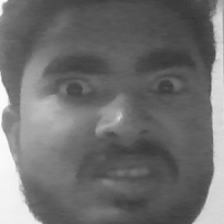

In [18]:
face_gray

In [19]:
"""ACTUAL OUTPUT OF THE MODEL, is a dictionary"""

emotions

[{'score': 0.8238824009895325, 'label': 'neutral'},
 {'score': 0.06828780472278595, 'label': 'fear'},
 {'score': 0.0489828921854496, 'label': 'surprise'},
 {'score': 0.022299576550722122, 'label': 'happy'},
 {'score': 0.017526384443044662, 'label': 'angry'}]

In [20]:
"""

GRAPHICAL USER INTERFACE

"""

# Function to play selected MP3 file
def play_audio(file_path):
    mixer.init()
    mixer.music.load(file_path)
    mixer.music.play()

# Function to stop playing audio
def stop_audio():
    mixer.music.stop()

# Create a folder for the dominant emotion if it doesn't exist
emotion_folder = os.path.join(os.getcwd(), dominant_emotion)
if not os.path.exists(emotion_folder):
    print(f"No audio files found for {dominant_emotion} emotion.")
else:
    # print(f"Emotion detected: {dominant_emotion}")




    # Create Tkinter window
    root = tk.Tk()
    root.title(f"Emotion: {dominant_emotion}")

    # Create listbox to display music files
    listbox = tk.Listbox(root, width=50) #width represents pixel
    listbox.pack(pady=10)

    # Populate listbox with MP3 files in emotion folder # LOAD ALL THE MUSIC FILE IN THE INTERFACE
    for file in os.listdir(emotion_folder):
        if file.endswith(".mp3"):
            listbox.insert(tk.END, file)

    # Function to play selected MP3 file
    def play_selected():
        selection = listbox.curselection()
        if selection:
            selected_file = listbox.get(selection[0])
            audio_path = os.path.join(emotion_folder, selected_file)
            play_audio(audio_path)

    # Function to handle window close event
    def on_close():
        stop_audio()
        root.destroy()

    # Create play button
    play_button = ttk.Button(root, text="Play", command=play_selected)
    play_button.pack(pady=10)

    # Bind window close event to stop playing audio
    root.protocol("WM_DELETE_WINDOW", on_close)

    root.mainloop()
